In [1]:
import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)
import pyvisa
import joblib


In [5]:
# funcgen = vs.connect(timeout=30000) # set 30 second timeout
funcgen = vs.connect("TCPIP0::192.168.1.9::inst0::INSTR", timeout=30000) # set 30 second timeout
# vs.disconnect(funcgen)

Connected to VISA [TCPIP0::192.168.1.9::inst0::INSTR]:  Agilent Technologies,81160A,MY60410882,2.0.0.0-2.6



In [4]:
vs.disconnect(funcgen)

In [2]:
data = joblib.load("avg_pulse.joblib")
time_series = data["time_series"]
avg_pulse = data["aligned_avg"]

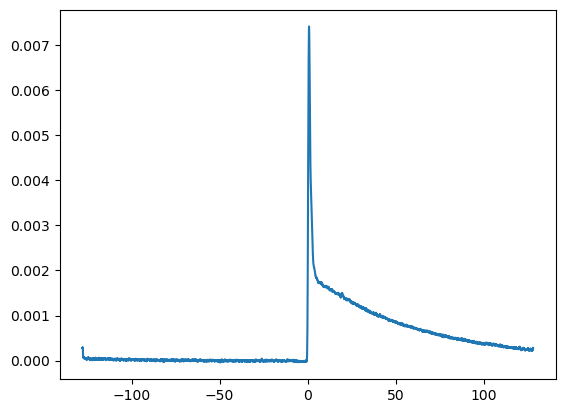

In [3]:
plot(time_series,avg_pulse)

/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:61: RuntimeWarning: divide by zero encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:61: RuntimeWarning: invalid value encountered in true_divide
  pulse/=max(pulse)


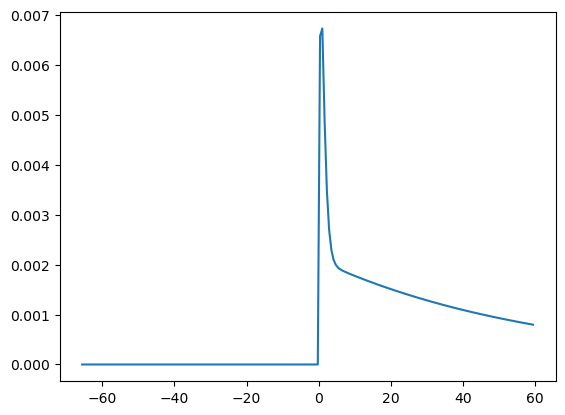

In [4]:
x = time_series
y = avg_pulse
popt, pconv, info, f = hp.fit_curve(hp.Pulse2,x[1000:3000],y[1000:3000],p0=[5,30,30,np.max(y),np.max(y),x[np.argmax(y)],np.max(y)])

# Example 1: generate a pulse repetitively 

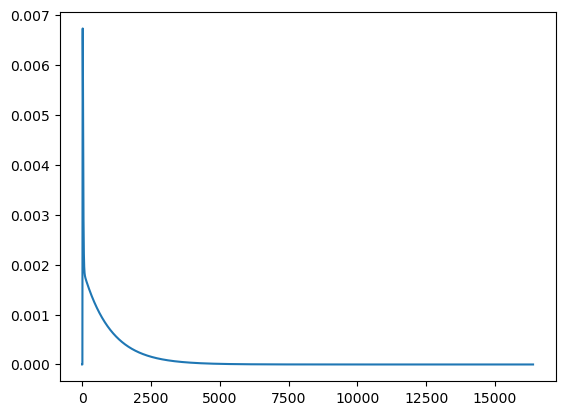

In [8]:
waveform_length = 16384
samples_per_ns = 16 # 2.5 Gsps --> 2.5 samples per ns
samples_per_s = samples_per_ns*1e9
waveform_duration = waveform_length/samples_per_ns
ch=1

time_series = (np.arange(waveform_length)-10)/samples_per_ns
# time_series = (np.arange(waveform_length)-waveform_length//2)/samples_per_ns
waveform_1eh = hp.Pulse2(time_series, *popt)
# waveform_14bit = hp.float_to_ADU(waveform, bits=14)    
plot(waveform_1eh)


In [6]:

reload(vs)

<module 'helper_visa' from '/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_visa.py'>

In [30]:
# funcgen = vs.connect(timeout=30000) # set 30 second timeout
funcgen = vs.connect("TCPIP0::192.168.1.9::inst0::INSTR", timeout=10000) # set 30 second timeout
# funcgen = vs.connect("USB0::0x0957::0x4108::MY60410882::0::INSTR", timeout=10000) # set 30 second timeout

# vs.disconnect(funcgen)

Connected to VISA [TCPIP0::192.168.1.9::inst0::INSTR]:  Agilent Technologies,81160A,MY60410882,2.0.0.0-2.6



In [29]:
vs.disconnect(funcgen)

## 1. Generate toy data waveform

In [38]:
funcgen.write(":DISP OFF");

100%|██████████| 10800/10800 [45:39<00:00,  3.94it/s]


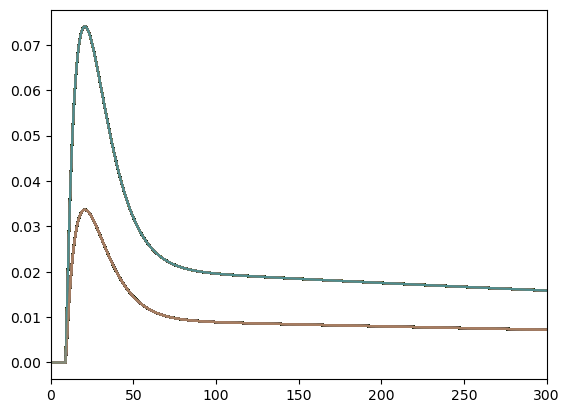

In [31]:
for i in tqdm(range(3600*3)):
# for i in tqdm(range(20)):
    
    INIT = True if i==0 else False

    # INIT=False

    funcgen.write(f":OUTPut1 OFF");      # Output the selected arb waveform  
    
    # funcgen.write(f":OUTPut2 OFF");      # Output the selected arb waveform  

    # Upload the first waveform
    j = np.random.choice([5,11])
    waveform_14bit = hp.float_to_ADU(waveform_1eh*j, bits=14)  
    output_voltage = np.max(waveform_1eh*j)*10
    if output_voltage<0.05:
        output_voltage = 0.05
    
    plot(waveform_1eh*j,alpha=0.2)
    xlim(0,300)
    vs.upload_waveform(funcgen, waveform_14bit, waveform_duration = waveform_duration, ch=1, trigger_mode="MAN", output_voltage=output_voltage, RESET=False, INIT=INIT)
    time.sleep(0.01)
    funcgen.write(f":OUTPut1 ON");      # Output the selected arb waveform  
    vs.trigger(funcgen)

    # time.sleep(0.1)
    
    # Upload the second waveform
    # j = np.random.randint(0,len(results_pulses))
    # waveform_14bit = hp.float_to_ADU(results_pulses[j], bits=14)  
    # output_voltage = np.max(results_pulses[j])*10
    # if output_voltage<0.05:
    #     output_voltage = 0.05
    # vs.upload_waveform(funcgen, waveform_14bit, waveform_duration = waveform_duration, ch=2, trigger_mode="MAN", output_voltage=output_voltage, RESET=False, INIT=INIT)
    # time.sleep(0.01)    
    
    
    # funcgen.write(f":OUTPut2 ON");      # Output the selected arb waveform        
    


In [ ]:
plot(results_pulses[j][:100])
axhline(0)

## 2. Generate the same averaged pulse 

In [ ]:
dummy_pulse_avg_normd = dummy_pulse_avg/max(dummy_pulse_avg)
output_voltage = max(dummy_pulse_avg)*20
waveform_14bit = hp.float_to_ADU(-dummy_pulse_avg, bits=14)  
vs.upload_waveform(funcgen, waveform_14bit, waveform_duration = waveform_duration, ch=ch, trigger_mode="MAN",trigger_freq=500, output_voltage=output_voltage, RESET=False)

In [ ]:
for i in tqdm(range(10000)):
    vs.trigger(funcgen)
    time.sleep(0.003)    

# Analysis

In [ ]:
DATA_DIR = "E:\\sync\\DT5550W\\"
filename = f"{DATA_DIR}\\176.data"

data  = hpt.load_finetime(filename, chs =["16","17"])

In [ ]:
mask_hit16 = (data["HIT_16"]==1)
mask_hit17 = (data["HIT_17"]==1)
mask_coinc = mask_hit16&mask_hit17

hist((data["CHARGE_17"]),bins=np.linspace(0,200,201),histtype="step", label="CH16");
hist((data["CHARGE_17"])[mask_hit17],bins=np.linspace(0,200,201),histtype="step", label="CH16");
hist((data["CHARGE_17"])[mask_coinc],bins=np.linspace(0,200,201),histtype="step", label="CH16");
yscale("log")
grid()

In [ ]:
sum(mask_hit16)

In [ ]:
h=hist(data["FINE_17"], bins=100);


In [ ]:
dt_coinc = (data.TIMESTAMP_16-data.TIMESTAMP_17)


ftime_min=ftime_max=None
bins=np.linspace(0,25,240)
ch="0"
normed=False

mask_peak1 = mask_coinc& (np.abs(data["CHARGE_17"]-100)<15)

h=hist(dt_coinc[mask_peak1], bins=np.linspace(-25,25,200));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
legend()
xlabel("dt [ns]")    
show()    

In [ ]:
import random

In [ ]:
inds1 = np.arange(len(dt_coinc))
inds2 = np.arange(len(dt_coinc))
random.shuffle(inds1)
random.shuffle(inds2)

dt_coinc_shuffled = dt_coinc.values[inds1]-dt_coinc.values[inds2]

bins=np.linspace(0,25,240)

h=hist(dt_coinc_shuffled, bins=np.linspace(-10,10,100));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
legend()
xlabel("dt [ns]")    
show()    

In [ ]:
3.7/1.4

### Averaged pulse

In [ ]:
DATA_DIR = "E:\\sync\\DT5550W\\"
filename = f"{DATA_DIR}\\174.data"

data  = hpt.load_finetime(filename, chs =["16","17"])

In [ ]:
mask_hit16 = (data["HIT_16"]==1)
mask_hit17 = (data["HIT_17"]==1)
mask_coinc = mask_hit16&mask_hit17

hist((data["CHARGE_17"]),bins=np.linspace(0,200,201),histtype="step", label="CH16");
hist((data["CHARGE_17"])[mask_coinc],bins=np.linspace(0,200,201),histtype="step", label="CH16");
yscale("log")
grid()

In [ ]:
bins=np.linspace(0,25,120)

hist(data.FINE_calib_17, bins=bins)
hist(data.FINE_calib_17[mask_coinc], bins=bins)
xlabel("Fine Time")
yscale("log")

In [ ]:
sum(mask_coinc)/len(mask_coinc)

In [ ]:
dt_coinc = (data.TIMESTAMP_16-data.TIMESTAMP_17)


ftime_min=ftime_max=None
bins=np.linspace(0,25,240)
ch="0"
normed=False

mask_peak1 = mask_coinc#& (np.abs(data["CHARGE_17"]-100)<15)

h=hist(dt_coinc[mask_peak1], bins=np.linspace(-15,5,200));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
legend()
xlabel("dt [ns]")    
show()    